In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_url = "datasets/income_datav2.csv"
test_url = "datasets/income_test_datav2.csv"

data = pd.read_csv(data_url)
test = pd.read_csv(test_url)

# A larger dataset than the previous training was used.
# Dimensions of the dataset used for training:
print(data.shape)

(199523, 42)


In [3]:
# Target Name: income_level

data["income_level"] = data["income_level"].apply(lambda x: 0 if x == " - 50000." else 1)
test["income_level"] = test["income_level"].apply(lambda x: 0 if x == " - 50000." else 1)

In [4]:
# Train - Validation -> 80 - 20

random_selection = np.random.rand(len(data.index)) <= 0.80
train_data = data[random_selection]
valid_data = data[~random_selection]
test_data = test.copy()

In [5]:
from functions import functions

# Batch Size: 256

train_data = functions.dataframe_to_dataset(train_data, "income_level", 256)
valid_data = functions.dataframe_to_dataset(valid_data, "income_level", 256)
test_data = functions.dataframe_to_dataset(test_data, "income_level", 256)

In [6]:
data.head().T

,0,1,2,3,4
age,73,58,18,9,10
class_of_worker,Not in universe,Self-employed-not incorporated,Not in universe,Not in universe,Not in universe
detailed_industry_recode,0,4,0,0,0
detailed_occupation_recode,0,34,0,0,0
education,High school graduate,Some college but no degree,10th grade,Children,Children
wage_per_hour,0,0,0,0,0
enroll_in_edu_inst_last_wk,Not in universe,Not in universe,High school,Not in universe,Not in universe
marital_stat,Widowed,Divorced,Never married,Never married,Never married
major_industry_code,Not in universe or children,Construction,Not in universe or children,Not in universe or children,Not in universe or children
major_occupation_code,Not in universe,Precision production craft & repair,Not in universe,Not in universe,Not in universe


In [7]:
header = data.columns

target_name = "income_level"
numerical_columns = ["age", "wage_per_hour", "capital_gains", "capital_losses", "dividends_from_stocks", "num_persons_worked_for_employer", "weeks_worked_in_year", "instance_weight"]
categorical_columns_integers = ["detailed_industry_recode", "detailed_occupation_recode", "own_business_or_self_employed", "veterans_benefits", "year"]

categorical_columns_strings = [col for col in header if col not in list([target_name] + numerical_columns + categorical_columns_integers) ]

In [8]:
# Model inputs of categorical and numerical features

categorical_inputs_strings = functions.input_Model(categorical_columns_strings, "string")
categorical_inputs_integers = functions.input_Model(categorical_columns_integers, "float32")
numerical_inputs_integers = functions.input_Model(numerical_columns, "float32")

In [9]:
vocabulary_string = [
    sorted([str(value) for value in list(data[feature_name].unique())]) for feature_name in categorical_columns_strings
]

vocabulary_integer = [
    sorted([str(value) for value in list(data[feature_name].unique())]) for feature_name in categorical_columns_integers
]

In [10]:
categorical_features_strings = functions.features_Model(categorical_inputs_strings,
                                               categorical_columns_strings, 
                                               train_data, 
                                               "categorical",
                                               is_string=True,
                                               use_embedding=True,
                                               vocabulary=vocabulary_string
                                               )

categorical_features_integers  = functions.features_Model(categorical_inputs_integers,
                                               categorical_columns_integers, 
                                               train_data, 
                                               "categorical",
                                               is_string=False,
                                               use_embedding=True,
                                               vocabulary=vocabulary_integer
                                               )
                                
numerical_features_integers =  functions.features_Model(numerical_inputs_integers,
                                              numerical_columns,
                                              train_data,
                                              "numerical",
                                              )

all_inputs = categorical_inputs_strings  + categorical_inputs_integers + numerical_inputs_integers

all_features = categorical_features_strings + categorical_features_integers + numerical_features_integers
all_features = keras.layers.concatenate(all_features)

c:\Users\HSN\anaconda3\envs\AI\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [11]:
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.fit(train_data, epochs=10, validation_data=valid_data)
model.evaluate(test_data)

Epoch 1/10
623/623 [==============================] - 23s 20ms/step - loss: 0.1707 - accuracy: 0.9441 - val_loss: 0.1248 - val_accuracy: 0.9508
Epoch 2/10
623/623 [==============================] - 15s 19ms/step - loss: 0.1251 - accuracy: 0.9502 - val_loss: 0.1230 - val_accuracy: 0.9512
Epoch 3/10
623/623 [==============================] - 15s 19ms/step - loss: 0.1229 - accuracy: 0.9511 - val_loss: 0.1229 - val_accuracy: 0.9525
Epoch 4/10
623/623 [==============================] - 15s 19ms/step - loss: 0.1220 - accuracy: 0.9514 - val_loss: 0.1224 - val_accuracy: 0.9524
Epoch 5/10
623/623 [==============================] - 15s 19ms/step - loss: 0.1212 - accuracy: 0.9519 - val_loss: 0.1223 - val_accuracy: 0.9532
Epoch 6/10
623/623 [==============================] - 15s 19ms/step - loss: 0.1208 - accuracy: 0.9519 - val_loss: 0.1223 - val_accuracy: 0.9505
Epoch 7/10
623/623 [==============================] - 15s 19ms/step - loss: 0.1204 - accuracy: 0.9520 - val_loss: 0.1217 - val_accuracy:

[0.11802298575639725, 0.9534993171691895]

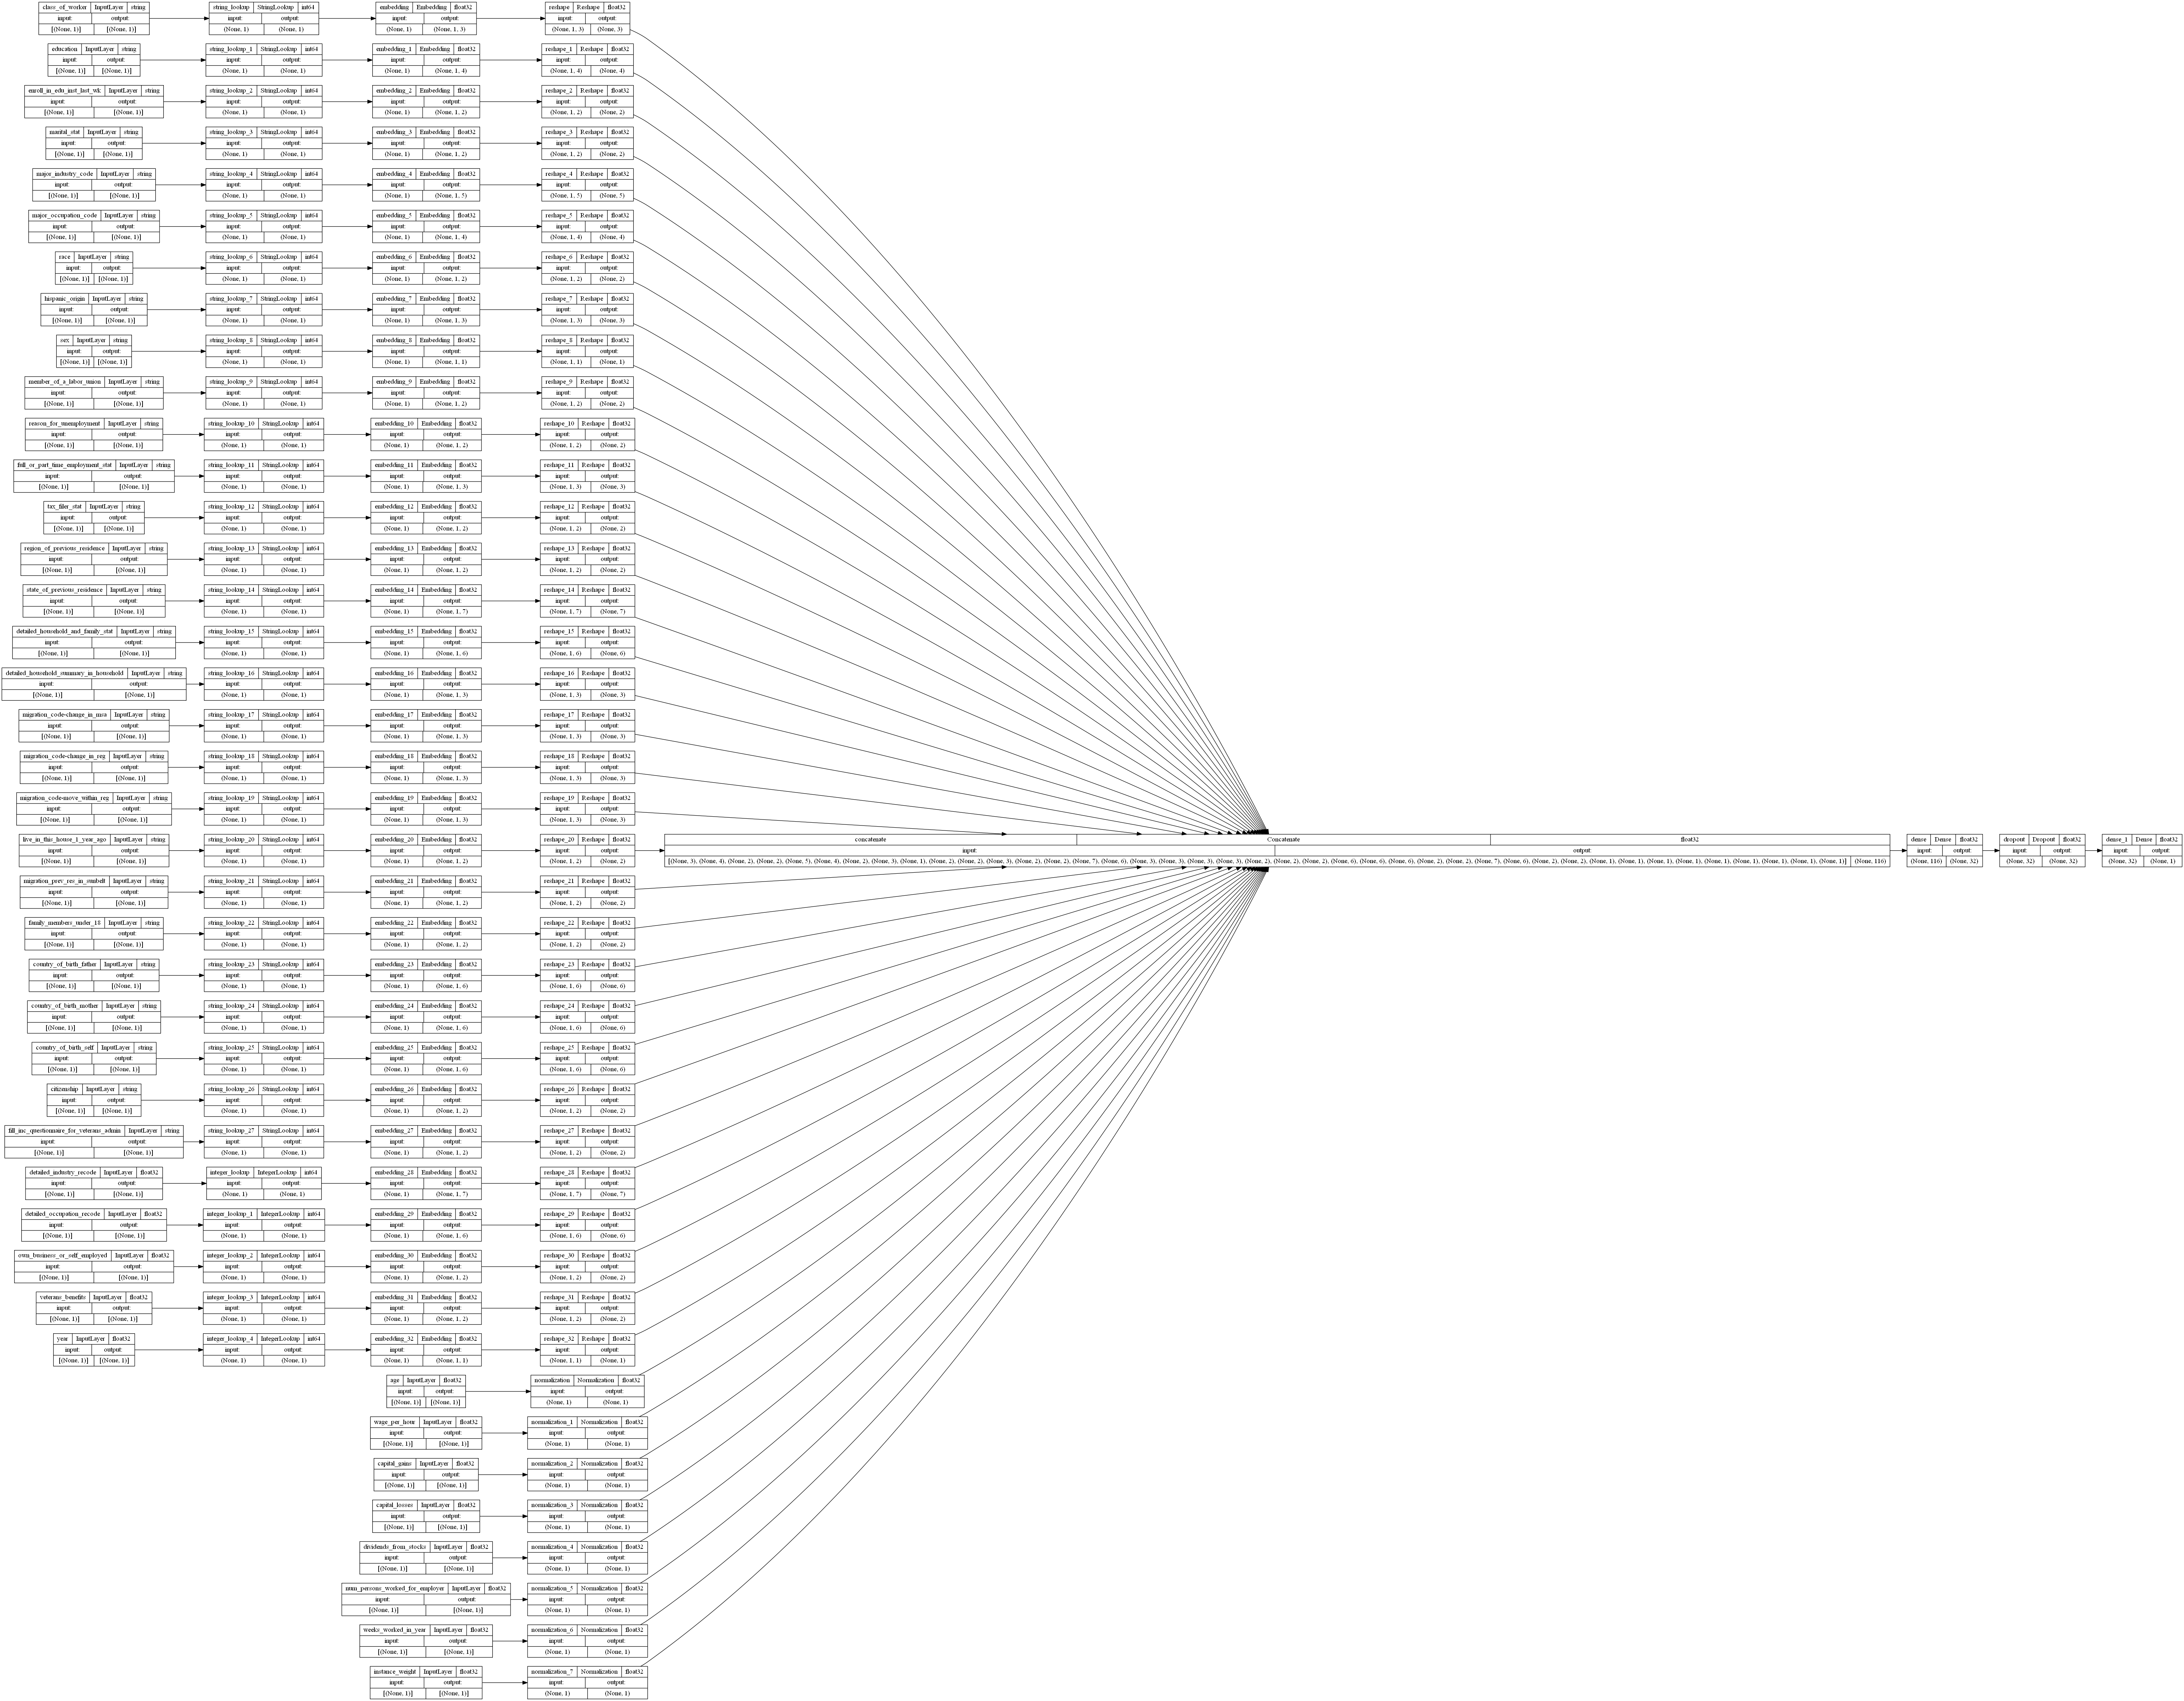

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, rankdir="LR")

## Source
https://keras.io/examples/structured_data/structured_data_classification_from_scratch/